In [113]:
import numpy as np
import h5py
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os

import sklearn.preprocessing as prep


name = '/home/mabbasloo/Documents/carData4/data/lbo/'
name1 = '/home/mabbasloo/Desktop/Variational-Lstm-Autoencoder/data/'

In [114]:
filename = '/home/mabbasloo/Desktop/Variational-Lstm-Autoencoder/list'
st = 10
stride = 6
with open(filename) as f:
    data = f.readlines() 
data = [x.strip() for x in data]   
data = sorted(data, key=lambda x:x[0:4])[0::stride]
print (len(data), np.int(len(data)/st))
for i in range(2*st):
    print (data[i])
#print (data[len(data)-1])
#for i in range(len(data)):
#    print (data[i])

2050 205
f001_S2000001_1.mat
f001_S2000001_7.mat
f001_S2000001_13.mat
f001_S2000001_19.mat
f001_S2000001_25.mat
f001_S2000001_31.mat
f001_S2000001_37.mat
f001_S2000001_43.mat
f001_S2000001_49.mat
f001_S2000001_55.mat
f002_S2000001_1.mat
f002_S2000001_7.mat
f002_S2000001_13.mat
f002_S2000001_19.mat
f002_S2000001_25.mat
f002_S2000001_31.mat
f002_S2000001_37.mat
f002_S2000001_43.mat
f002_S2000001_49.mat
f002_S2000001_55.mat


In [115]:
DATA = []
d = 30
#hm = 20*st
hm = len(data)
dimm = 1714
db = h5py.File(name + data[0], 'r')
ds = db['Phi']
ds = np.asarray(ds).astype(np.float32).T
ds = ds[:, 0:d]
ds[np.isnan(ds)] = 0.0
ds[np.isinf(ds)] = 0.0
for i in range(hm):
    #db = h5py.File(name + data[i], 'r')
    #ds = db['Phi']
    #ds = np.asarray(ds).astype(np.float32).T
    #ds = ds[:, 500-d:]
    #print (ds.shape)
    db1 = h5py.File(name1 + data[i], 'r')
    ds1 = db1['shape_xyz']
    ds1 = np.asarray(ds1).astype(np.float32)
    ds1[np.isnan(ds1)] = 0.0
    ds1[np.isinf(ds1)] = 0.0  
    #ds1[0] = ds1[0]/np.linalg.norm(ds1[0])
    #ds1[1] = ds1[1]/np.linalg.norm(ds1[1])
    #ds1[2] = ds1[2]/np.linalg.norm(ds1[2])   
    if ds1.shape[1] == dimm: # f256_S2000001_6.mat has different dimension so f256_S2000001* are removed.
        DATA.append(np.dot(ds1, ds))
    else:
        print (data[i])     

lx = np.linalg.norm(DATA[:][0][:])
ly = np.linalg.norm(DATA[:][1][:])
lz = np.linalg.norm(DATA[:][2][:])
for i in range(hm):
    DATA[i][0] = DATA[i][0]/lx
    DATA[i][1] = DATA[i][1]/ly
    DATA[i][2] = DATA[i][2]/lz 
    
#def standard_scale(X_train):
#    for i in range(len(X_train)):
#        X_train[i] = X_train[i]/np.linalg.norm(X_train[i], 'fro')
#    return X_train

#DATA = standard_scale(DATA)

dim = np.int(len(data)/st)

print (len(DATA), DATA[0].shape, dim)

2050 (3, 30) 205


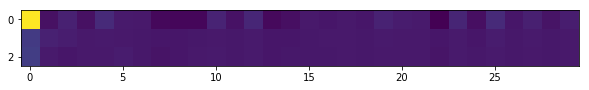

In [116]:
plt.figure(figsize=(10, 10)); plt.imshow(DATA[0])

Text(0.5, 0, 'z')

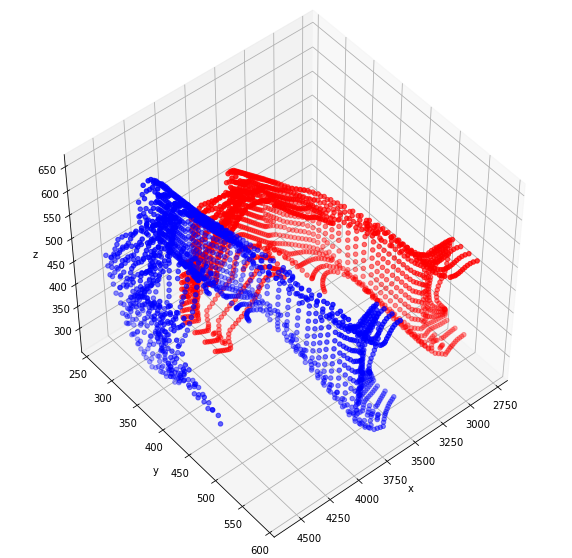

In [117]:
db1 = h5py.File(name1 + data[0], 'r')
ds1 = db1['shape_xyz']
ds1 = np.asarray(ds1).astype(np.float32)
db2 = h5py.File(name1 + data[9], 'r')
ds2 = db2['shape_xyz']
ds2 = np.asarray(ds2).astype(np.float32)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ds1[0], ds1[1], ds1[2], c='r', marker='o')
ax.scatter(ds2[0], ds2[1], ds2[2], c='b', marker='o')
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

(3, 1714)


Text(0.5, 0, 'z')

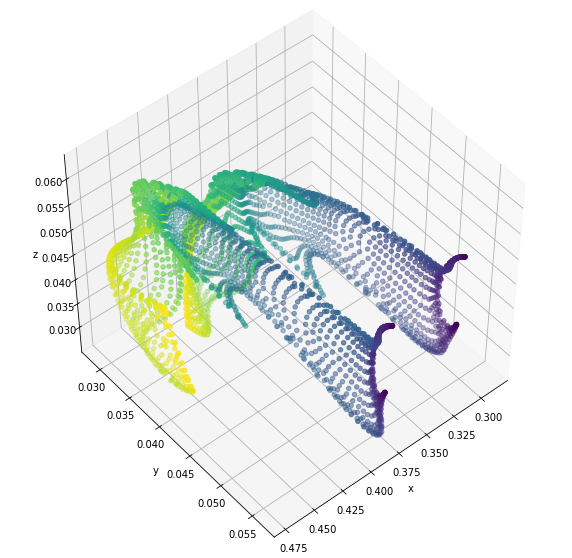

In [118]:
xyz1 = np.dot(DATA[0], np.linalg.pinv(ds))
xyz2 = np.dot(DATA[9], np.linalg.pinv(ds))
print (xyz1.shape)
cl1 = np.linalg.norm(np.abs(xyz1 - ds1), axis=0)
cl1 = (cl1-np.amin(cl1))/(np.amax(cl1)-np.amin(cl1))
cl2 = np.linalg.norm(np.abs(xyz2 - ds2), axis=0)
cl2 = (cl2-np.amin(cl2))/(np.amax(cl2)-np.amin(cl2))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz1[0], xyz1[1], xyz1[2], c=cl1, marker='o')
ax.scatter(xyz2[0], xyz2[1], xyz2[2], c=cl2, marker='o')
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [119]:
DATA3 = []
for i in range(dim):
    D = np.asarray(DATA[i*st:(i+1)*st]).reshape(st*3, d)
    DATA3.append(D)
print (len(DATA3), DATA3[0].shape)  
ddd = st*3
print (ddd, d)
dim3 = 100

205 (30, 30)
30 30


In [124]:
# lstm autoencoder reconstruct and predict sequence
from numpy import array
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model



# define input sequence
#[samples, timesteps, features]
seq_in = []
for j in range(dim3):
    seq_in.append(DATA3[j].reshape(st, 3*d))
seq_in = np.asarray(seq_in)  
print (seq_in.shape)

seq_test = []
for j in range(dim3, 205):
    seq_test.append(DATA3[j].reshape(st, 3*d))
seq_test = np.asarray(seq_test)  
print (seq_test.shape)

n_in = seq_in.shape[1]

# prepare output sequence
l = 5
seq_out = seq_in[:, l:, :]
n_out = n_in - l

# define encoder
visible = Input(shape=(n_in, 3*d))
encoder = LSTM(500, activation='relu')(visible)

# define reconstruct decoder
decoder1 = RepeatVector(n_in)(encoder)
decoder1 = LSTM(500, activation='relu', return_sequences=True)(decoder1)
decoder1 = TimeDistributed(Dense(3*d))(decoder1)

# define predict decoder
decoder2 = RepeatVector(n_out)(encoder)
decoder2 = LSTM(500, activation='relu', return_sequences=True)(decoder2)
decoder2 = TimeDistributed(Dense(3*d))(decoder2)

# tie it together
model = Model(inputs=visible, outputs=[decoder1, decoder2])
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True, to_file='composite_lstm_autoencoder.png')

(100, 10, 90)
(105, 10, 90)


In [125]:
# fit model
model.fit(seq_in, [seq_in,seq_out], epochs=200, verbose=1)

Epoch 1/200
100/100 [==============================] - 7s 66ms/step - loss: 0.0241 - time_distributed_19_loss: 0.0115 - time_distributed_20_loss: 0.0126
Epoch 2/200
100/100 [==============================] - 1s 11ms/step - loss: 0.0094 - time_distributed_19_loss: 0.0041 - time_distributed_20_loss: 0.0052
Epoch 3/200
100/100 [==============================] - 1s 13ms/step - loss: 0.0038 - time_distributed_19_loss: 0.0018 - time_distributed_20_loss: 0.0021
Epoch 4/200
100/100 [==============================] - 1s 14ms/step - loss: 0.0044 - time_distributed_19_loss: 0.0025 - time_distributed_20_loss: 0.0019
Epoch 5/200
100/100 [==============================] - 1s 11ms/step - loss: 0.0028 - time_distributed_19_loss: 0.0013 - time_distributed_20_loss: 0.0014
Epoch 6/200
100/100 [==============================] - 1s 9ms/step - loss: 0.0018 - time_distributed_19_loss: 8.2753e-04 - time_distributed_20_loss: 9.8815e-04
Epoch 7/200
100/100 [==============================] - 1s 10ms/step - loss:

In [126]:
# demonstrate prediction
yhat = model.predict(seq_test, verbose=1)

print (len(yhat), yhat[0].shape)

105/105 [==============================] - 2s 15ms/step
2 (105, 10, 90)


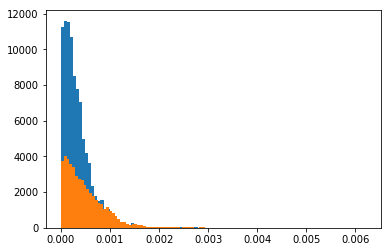

In [127]:
_,_,_ = plt.hist(np.abs(yhat[0] - seq_test).reshape(seq_test.shape[0]*seq_test.shape[1]*seq_test.shape[2]), bins=100)
_,_,_ = plt.hist(np.abs(yhat[1] - seq_test[:, l:, :]).reshape(seq_test.shape[0]*(seq_test.shape[1]-l)*seq_test.shape[2]), bins=100)

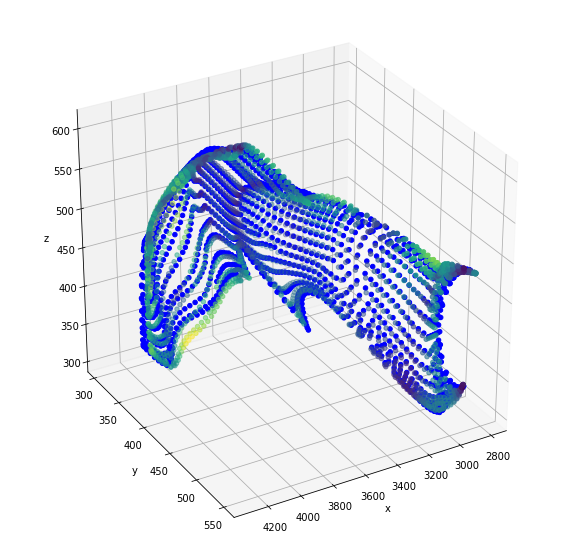

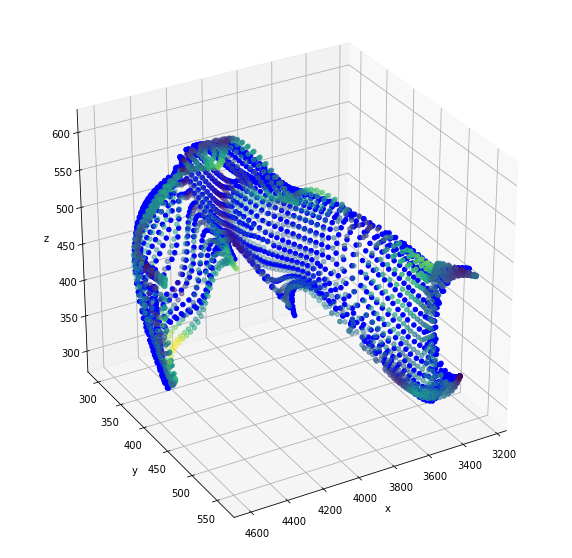

In [128]:
x_reconstructed3 = yhat[0].reshape(205-dim3, (st)*3, d)
lxyz = np.array([[lx, 0, 0],
                 [0, ly, 0],
                 [0, 0, lz]])
for i in range(0, st, 5):
    xyz3 = np.dot(np.dot(lxyz, DATA[dim3*st+i]), np.linalg.pinv(ds))
    xyz_reconstructed3 = np.dot(np.dot(lxyz, x_reconstructed3[0, i*3:(i+1)*3]), np.linalg.pinv(ds))
    cl = np.linalg.norm(np.abs(xyz3 - xyz_reconstructed3), axis=0)
    cl = (cl-np.amin(cl))/(np.amax(cl)-np.amin(cl))
    fig = plt.figure(figsize=(10, 10))
    c = ['b', 'r']
    m = ['o', 'o']
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xyz_reconstructed3[0], xyz_reconstructed3[1], xyz_reconstructed3[2], c=cl, marker=m[1])
    ax.scatter(xyz3[0], xyz3[1], xyz3[2], c=c[0], marker=m[0], alpha=1.0)
    ax.view_init(30, 60)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z') 

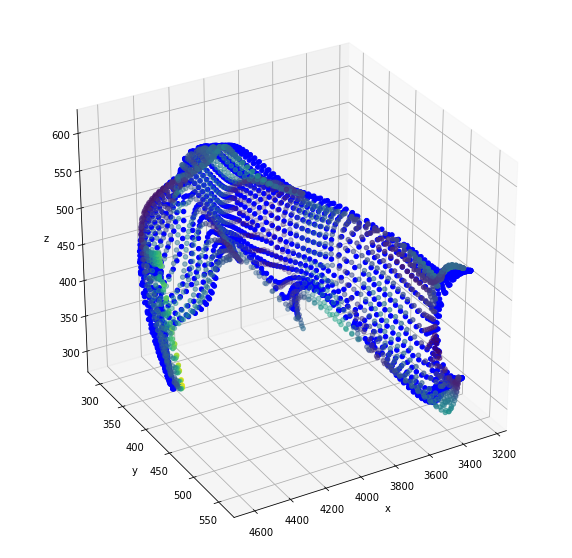

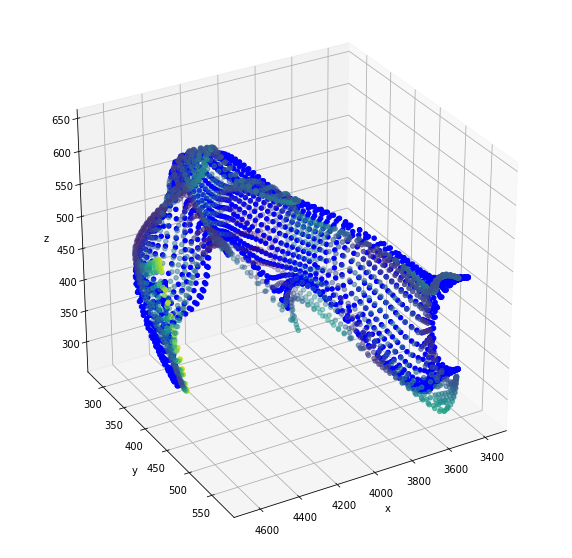

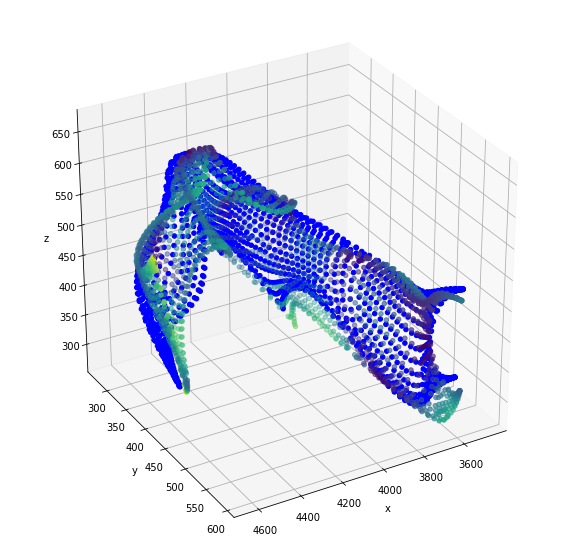

In [130]:
x_reconstructed3 = yhat[1].reshape(205-dim3, (st-l)*3, d) 
for i in range(l, st, 2):
    xyz3 = np.dot(np.dot(lxyz, DATA[dim3*st+i]), np.linalg.pinv(ds))
    xyz_reconstructed3 = np.dot(np.dot(lxyz, x_reconstructed3[0, (i-l)*3:(i-l+1)*3]), np.linalg.pinv(ds))
    cl = np.linalg.norm(np.abs(xyz3 - xyz_reconstructed3), axis=0)
    cl = (cl-np.amin(cl))/(np.amax(cl)-np.amin(cl))
    fig = plt.figure(figsize=(10, 10))
    c = ['b', 'r']
    m = ['o', 'o']
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xyz_reconstructed3[0], xyz_reconstructed3[1], xyz_reconstructed3[2], c=cl, marker=m[1])
    ax.scatter(xyz3[0], xyz3[1], xyz3[2], c=c[0], marker=m[0], alpha=1.0)
    ax.view_init(30, 60)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')